In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15,5)

In [16]:
NYT_train_raw = pd.read_csv("NYTimesBlogTrain.csv")
NYT_test_raw = pd.read_csv("NYTimesBlogTest.csv")

Join the data for preprocessing

In [17]:
print('Max train ID: %d. Max test ID: %d' % (np.max(NYT_train_raw['UniqueID']), np.max(NYT_test_raw['UniqueID'])))
joined = NYT_train_raw.merge(NYT_test_raw, how = 'outer')

Max train ID: 6532. Max test ID: 8402


Create additional features:
* "QorE": question or exclamation mark in the headline
* "Q&A": "Q. and A." phrase in the headline (I don't think it was valuable, but stayed here from my previous attemps)

In [18]:
joined['QorE'] = joined['Headline'].str.contains(r'\!|\?').astype(int)
joined['Q&A'] = joined['Headline'].str.contains(r'Q\. and A\.').astype(int)

Convert "PubDate" into two columns: Weekday and Hour:

In [19]:
joined['PubDate'] = pd.to_datetime(joined['PubDate'])
joined['Weekday'] = joined['PubDate'].dt.weekday
joined['Hour'] = joined['PubDate'].dt.hour

In [20]:
print("At the moment, we have %d entries with NewsDesk=Nan." % len(joined.loc[joined['NewsDesk'].isnull()]))

At the moment, we have 2408 entries with NewsDesk=Nan.


###More features and gap filling
Below are the results of one day of searching for meaningful patterns in the data. There are a few easily identifiable features, most of which lead to zero popularity. They are:
* "History": article headings always started with a year. None of them were popular in the training set
* "Daily rubric": I added this new NewsDesk category for types of articles that appeared regularly (not necessarily daily): "Daily Clip Report", "Today in Politics", "What we're reading", "First Draft", "Pictures of the day", "Week in pictures". They also were not popular.

Now, as **ask788** pointed out in [this thread](http://www.kaggle.com/c/15-071x-the-analytics-edge-competition-spring-2015/forums/t/13966/is-the-hype-around-data-overrated), the problem with data is often their structure, not the models we use on them. I agree that ideally this feature engineering should have been done automatically, but I am a novice, and had to tediously plod through the rows of data manually.

You can browse individual features that I selected by printing the `head()` of a subset, like so:

In [21]:
joined.loc[(joined['NewsDesk'] == 'Foreign') & (joined['SectionName'].isnull())].head()

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,Popular,UniqueID,QorE,Q&A,Weekday,Hour
11,Foreign,NaN,NaN,1939: German Troops Invade Poland,Highlights from the International Herald Tribu...,Highlights from the International Herald Tribu...,97,2014-09-01 14:39:43,0,12,0,0,0,14
20,Foreign,NaN,NaN,1914: Russian Army Scores Victory,Highlights from the International Herald Tribu...,Highlights from the International Herald Tribu...,108,2014-09-01 09:30:14,0,21,0,0,0,9
67,Foreign,NaN,NaN,1914: City Prepares for War Wounded,Highlights from the International Herald Tribu...,Highlights from the International Herald Tribu...,101,2014-09-02 13:34:59,0,68,0,0,1,13
81,Foreign,NaN,NaN,1889: British Traders in East Africa,Highlights from the International Herald Tribu...,Highlights from the International Herald Tribu...,122,2014-09-02 10:48:08,0,82,0,0,1,10
184,Foreign,NaN,NaN,1939: War on Germany Declared,Highlights from the International Herald Tribu...,Highlights from the International Herald Tribu...,79,2014-09-03 07:41:26,0,185,0,0,2,7


In [22]:
joined.loc[(joined['NewsDesk'] == 'Styles') & (joined['SectionName'].isnull()), 'NewsDesk'] = 'TStyle'
joined.loc[(joined['NewsDesk'] == 'Foreign') & (joined['SectionName'].isnull()), 'NewsDesk'] = 'History'
joined.loc[(joined['NewsDesk'].isnull()) & (joined['Headline'].str.contains(r'^1[0-9]{3}')), 'NewsDesk'] = 'History'
joined.loc[(joined['NewsDesk'].isnull()) & (joined['Headline'] == 'Daily Clip Report'), 'NewsDesk'] = 'Daily Rubric'
joined.loc[joined['NewsDesk'] == 'Daily Rubric', 'SectionName'] = 'Clip Report'
joined.loc[(joined['NewsDesk'].isnull()) & (joined['Headline'] == 'Today in Politics'), 'SectionName'] = 'Today in Politics'
joined.loc[joined['SectionName'] == 'Today in Politics', 'NewsDesk'] = 'Daily Rubric'
joined.loc[(joined['NewsDesk'].isnull()) & (joined['Headline'].str.contains(r'what we\'re reading', case=False)), 'SectionName'] = 'What we\'re reading'
joined.loc[joined['SectionName'] == 'What we\'re reading', 'NewsDesk'] = 'Daily Rubric'
joined.loc[(joined['NewsDesk'].isnull()) & (joined['Headline'].str.contains(r'first draft', case=False)), 'SectionName'] = 'First draft'
joined.loc[joined['SectionName'] == 'First draft', 'NewsDesk'] = 'Daily Rubric'
joined.loc[(joined['NewsDesk'].isnull()) & (joined['SubsectionName'] == 'Education'), 'NewsDesk'] = 'Daily Rubric'
joined.loc[(joined['Headline'].str.contains('pictures of the day|week in pictures', case=False)), 'NewsDesk'] = 'Daily Rubric'

Filling the gaps in NewsDesk, SectionName and SubsectionName.

In [23]:
section_to_newsdesk = {'Business Day': 'Business', 'Crosswords/Games': 'Business', 'Technology': 'Business',
     'Arts': 'Culture',
     'World': 'Foreign',
     'Magazine': 'Magazine',
     'N.Y. / Region': 'Metro',
     'Opinion': 'OpEd',
     'Travel': 'Travel',
     'Multimedia': 'Multimedia',
     'Open': 'Open'}

section_to_subsection = {'Crosswords/Games': 'Crosswords/Games',
                        'Technology': 'Technology'}

newsdesk_to_section = {'TStyle': 'TStyle',
                      'Culture': 'Arts',
                      'OpEd': 'Opinion',
                      'History': 'History'}

newsdesk_to_subsection = {'TStyle': 'TStyle',
                         'Culture': 'Arts',
                         'Daily Rubric': 'Rubric',
                         'Magazine': 'Magazine',
                         'Metro': 'Metro',
                         'Multimedia': 'Multimedia',
                         'OpEd': 'OpEd',
                         'Science': 'Science',
                         'Sports': 'Sports',
                         'Styles': 'Styles',
                         'Travel': 'Travel',
                         'History': 'History'}
     
for sec in set(joined['SectionName']):
    try: section_to_newsdesk[sec]
    except KeyError:
        pass
    else:
        joined['NewsDesk'].fillna(joined.loc[(joined['SectionName'] == sec)]['NewsDesk'].fillna(section_to_newsdesk[sec]), inplace=True)

    try: section_to_subsection[sec]
    except KeyError:
        pass
    else:
        joined['SubsectionName'].fillna(joined.loc[(joined['SectionName'] == sec)]['SubsectionName'].fillna(section_to_subsection[sec]), inplace=True)        


for nd in set(joined['NewsDesk']):
    try: newsdesk_to_section[nd]
    except KeyError:
        pass
    else:
        joined['SectionName'].fillna(joined.loc[(joined['NewsDesk'] == nd)]['SectionName'].fillna(newsdesk_to_section[nd]), inplace=True)
        
    try: newsdesk_to_subsection[nd]
    except KeyError:
        pass
    else:
        joined['SubsectionName'].fillna(joined.loc[(joined['NewsDesk'] == nd)]['SubsectionName'].fillna(newsdesk_to_subsection[nd]), inplace=True)

Filling even more gaps with some clustering. I created a TFI-DF matrix and did Ward clustering on words. Four of six clusters I thought were meaningful and fitted well into existing NewsDesk/S(ubs)ectionName.

In [24]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

nans = joined.loc[joined['NewsDesk'].isnull()]
words = list(nans.apply(lambda x:'%s' % (x['Abstract']),axis=1))
tfv = TfidfVectorizer(min_df=0.005,  max_features=None, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
        stop_words = 'english')
X_tr = tfv.fit_transform(words)

ward = AgglomerativeClustering(n_clusters=6,
        linkage='ward').fit(X_tr.toarray())

joined.loc[joined['NewsDesk'].isnull(), 'cluster'] = ward.labels_
cluster_to = {}
cluster_to['NewsDesk'] = {4: 'Metro', 3: 'National', 2: 'Foreign', 1: 'National'}
cluster_to['SectionName'] = {4: 'N.Y. / Region', 3: 'U.S.', 2: 'Not_Asia', 1: 'U.S.'}
cluster_to['SubsectionName'] = {4: 'NYT', 3: 'Politics', 2: 'Not_Asia', 1: 'Politics'}

for key in cluster_to:
    for key2 in cluster_to[key]:
        joined.loc[(joined['cluster'] == key2) & (nans['NewsDesk'].isnull()), key] = cluster_to[key][key2]

You can see what these clusters look like by typing:

In [26]:
joined.loc[joined['cluster'] == 3].head()

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,Popular,UniqueID,QorE,Q&A,Weekday,Hour,cluster
1510,National,U.S.,Politics,Congress to Weigh In on White House Security,The House Committee on Oversight and Governmen...,The House Committee on Oversight and Governmen...,98,2014-09-22 16:50:03,0,1511,0,0,0,16,3
1540,National,U.S.,Politics,White House Will Use Locks More Often,White House Not Changing the Locks Just Yet,White House Not Changing the Locks Just Yet,304,2014-09-22 12:49:19,0,1541,0,0,0,12,3
1569,National,U.S.,Politics,"The White House Front Door, When Entered Properly",A brief history of the White Houses North Port...,A brief history of the White Houses North Port...,220,2014-09-22 10:18:46,0,1570,0,0,0,10,3
1672,National,U.S.,Politics,Lunchtime Laughs: Jumper at 1600,The Daily Shows take on the disturbing details...,The Daily Shows take on the disturbing details...,114,2014-09-23 12:40:54,0,1673,0,0,1,12,3
1776,National,U.S.,Politics,White House Reporters Working on Pool End-Around,The White House Correspondents Association is ...,The White House Correspondents Association is ...,210,2014-09-24 14:46:28,0,1777,0,0,2,14,3


Finally, use a few (6) obvious keywords to categorise the data even more. After this, we are left with 950 entries where NewsDesk, SectionName and SubsectionName are NaN, but I didn't have an idea how to deal with them.

In [ ]:
joined.drop('cluster', axis=1, inplace=True)

In [29]:
keywords = {}
keywords['clinton|white house|obama'] = {'NewsDesk': 'National', 'SectionName': 'U.S.', 'SubsectionName': 'Politics'}
keywords['isis|iraq'] = {'NewsDesk': 'Foreign', 'SectionName': 'Not_Asia', 'SubsectionName': 'Not_Asia'}
keywords['york'] = {'NewsDesk': 'Metro', 'SectionName': 'N.Y. / Region', 'SubsectionName': 'N.Y. / Region'}

for key in keywords:
    indices = (joined['NewsDesk'].isnull()) & (joined['Abstract'].str.contains(key, case=False))
    for sec in keywords[key]:
        joined.loc[indices, sec] = keywords[key][sec]

In [30]:
print("Now we have %d entries with NewsDesk=Nan." % len(joined.loc[joined['NewsDesk'].isnull()]))

Now we have 948 entries with NewsDesk=Nan.


###Categorical (factor) colums
First, turn the categorial data into 0/1 binary columns. Yes, it's more painful in Python than in R.

In [31]:
from sklearn.feature_extraction import DictVectorizer

def categorizeDF(df):
    old_columns = df.columns
    cat_cols = ['NewsDesk', 'SectionName', 'SubsectionName']
    temp_dict = df[cat_cols].to_dict(orient="records")
    vec = DictVectorizer()
    vec_arr = vec.fit_transform(temp_dict).toarray()
    
    new_df = pd.DataFrame(vec_arr).convert_objects(convert_numeric=True)
    new_df.index = df.index
    new_df.columns = vec.get_feature_names()
    columns_to_add = [col for col in old_columns if col not in cat_cols]
    new_df[columns_to_add] = df[columns_to_add]
    new_df.drop(cat_cols, inplace=True, axis=1)
    return new_df

joined_cat = categorizeDF(joined)

###Recover train and test sets

In [32]:
train = joined_cat[joined_cat['UniqueID'] <= 6532]
test = joined_cat[joined_cat['UniqueID'] > 6532]

###Random Forest
Parametres for RF had been optimised with a `GridSearchCV` function from `sklearn`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

Xcols = train.columns
Xcols = [x for x in Xcols if not x in ('Headline', 'Snippet', 'Abstract', 'PubDate', 'UniqueID', 'Popular')]

y = train['Popular']

forest = RandomForestClassifier(n_estimators=7000, max_features=0.1, min_samples_split=24, random_state=33, n_jobs=3)
forest.fit(train[Xcols], y)

probsRF = forest.predict_proba(test[Xcols])[:,1]

print("10 Fold CV Score: ", np.mean(cross_validation.cross_val_score(forest, train[Xcols], y, cv=10, scoring='roc_auc')))

###Gradient Boosting Method

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation

Xcols = train.columns
Xcols = [x for x in Xcols if not x in ('Headline', 'Snippet', 'Abstract', 'PubDate', 'UniqueID', 'Popular', 'Q&A')]

y = train['Popular']

est = GradientBoostingClassifier(n_estimators=3000,
                                 learning_rate=0.005,
                                 max_depth=4,
                                 max_features=0.3,
                                 min_samples_leaf=9,
                                 random_state=33)
est.fit(train[Xcols], y)

probsGBC = est.predict_proba(test[Xcols])[:,1]

print("10 Fold CV Score: ", np.mean(cross_validation.cross_val_score(est, train[Xcols], y, cv=10, scoring='roc_auc')))

10 Fold CV Score:  0.945608635167


Define a function for cross-validating and plotting ensemble of my two models:

In [27]:
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score

def calculate_ensemble_score(model1, model2, Xcols, ycol, dataset, cv=10):
    '''Calculates the score for various weights of two models in an ensemble'''
    
    num_points = 21
    score_arr = np.zeros((cv, num_points))
    
    kf = cross_validation.KFold(len(dataset), cv, shuffle=True)

    i = 0
    for xtrain, xtest in kf:
        train, test = dataset.ix[xtrain], dataset.ix[xtest]
        
        model1.fit(train[Xcols], train[ycol])
        probs1 = model1.predict_proba(test[Xcols])[:,1]
       
        model2.fit(train[Xcols], train[ycol])
        probs2 = model2.predict_proba(test[Xcols])[:,1]
        
        for wg in range(num_points):
            probs = wg/(num_points-1)*probs1 + (1-wg/(num_points-1))*probs2
            score_arr[i][wg] = roc_auc_score(test[ycol], probs)
        
        i+=1
    
    return np.mean(score_arr, axis=0)
            
def plot_ensemble_score(scores):
    import seaborn as sbs

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axhline(y=scores[0], linestyle='--', color='red')
    ax.axhline(y=scores[-1], linestyle='--', color='green')
    ax.text(0.0, scores[0]+0.0001, "Pure RF", verticalalignment='bottom', horizontalalignment='left', color='red', size='larger')
    ax.text(0.0, scores[-1]+0.0001, "Pure GBM", verticalalignment='bottom', horizontalalignment='left', color='green', size='larger')

    ax.plot(np.linspace(0,1,len(scores)), scores)
    ax.set_xlabel("RF model weight")
    ax.set_ylabel("AUC")
    ax.set_title("Choosing the weights for two models in an ensemble (10-fold cross-validation)")
    
    return fig

In [25]:
means = calculate_ensemble_score(forest, est, Xcols, 'Popular', train)

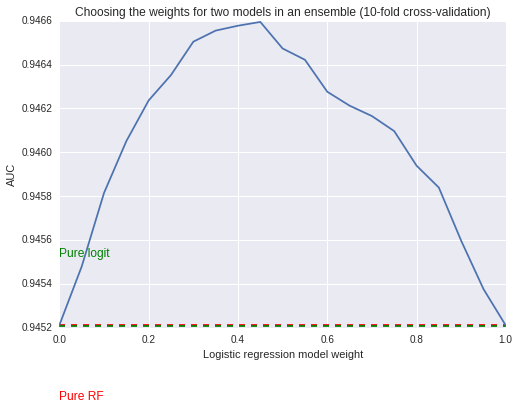

In [28]:
myplot = plot_ensemble_score(means)
myplot.savefig("AUC.png", dpi=300)

In [30]:
test.loc['Popular'] = (0.6*probsGBC+0.4*probsRF)
test.loc['UniqueID'] = test.loc['UniqueID'].astype(int)
test.to_csv('preds.csv', columns=['UniqueID', 'Popular'], header=['UniqueID', 'Probability1'], index=False)

/home/ak763/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ak763/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


Kaggle: 0.93613.